In [17]:
import torch
from torch import nn
import math
import numpy as np

In [18]:
SEED = 42
LOOKBACK = 30
FORECAST = 7
BATCH_SIZE = 64

torch.random.manual_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [19]:
class Embedding(nn.Module):
    def __init__(self, num_features, d_model=512):
        super(Embedding, self).__init__()
        self.linear = nn.Linear(num_features, d_model)

    def forward(self, x):
        x = self.linear(x)
        return x

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=512, max_len=5000):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        encoding = encoding.unsqueeze(0)

        # Register the encoding as a buffer so it is not a model parameter
        self.register_buffer('encoding', encoding)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

In [21]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, num_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.drop = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Q的形状: [batch_size, num_heads, seq_len, d_k]
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 如果提供了mask，则将其应用于注意力分数
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
            
        # 应用softmax获取注意力权重
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.drop(attn_weights)
        
        # 应用注意力权重到值(V)
        output = torch.matmul(attn_weights, V)
        
        return output
    
    def split_heads(self, x):
        # 输入x的形状: [batch_size, seq_len, d_model]
        batch_size, seq_len = x.size(0), x.size(1)
        
        # 重塑为 [batch_size, seq_len, num_heads, d_k]
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)
        
        # 转置为 [batch_size, num_heads, seq_len, d_k]
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        # 输入x的形状: [batch_size, num_heads, seq_len, d_k]
        batch_size, _, seq_len = x.size(0), x.size(1), x.size(2)
        
        # 转置回 [batch_size, seq_len, num_heads, d_k]
        x = x.transpose(1, 2)
        
        # 重塑为 [batch_size, seq_len, d_model]
        return x.contiguous().view(batch_size, seq_len, self.d_model)
    
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        # 线性变换
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        
        # 分割头
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # 应用缩放点积注意力
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 合并头
        output = self.combine_heads(attn_output)
        
        # 最终线性变换
        output = self.W_o(output)
        
        return output

In [22]:
class FeedForward(nn.Module):
    def __init__(self, d_model=512, d_ff=2048):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [23]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.self_attn(x, x, x)
        x = self.drop(x)
        x = self.norm1(x + residual)
        
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm2(x + residual)
        
        return x

In [24]:
class Encoder(nn.Module):
    def __init__(self, num_feature,num_layers=6, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = Embedding(num_feature,d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)

        for layer in self.layers:
            x = layer(x)
        
        return x

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm3 = nn.LayerNorm(d_model)

        self.drop = nn.Dropout(dropout)

    def forward(self, x, encode_ouput, mask):
        residual = x
        x = self.self_attn(x, x, x, mask)
        x = self.drop(x)
        x = self.norm1(x + residual)
        
        residual = x
        x = self.enc_dec_attn(x, encode_ouput, encode_ouput)
        x = self.drop(x)
        x = self.norm2(x + residual)
        
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm3(x + residual)
        
        return x

In [26]:
class Decoder(nn.Module):
    def __init__(self, num_feature,num_layers=6, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = Embedding(num_feature,d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_feature)
        
        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_output, mask):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)

        for layer in self.layers:
            x = layer(x, enc_output, mask)

        x = self.fc(x)
        
        return x

In [27]:
def create_look_ahead_mask(size):
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
    return mask == 0

In [28]:
def infer(encoder, decoder, inputs, infer_steps):
    """
    inputs: [1, seq_len, num_features]
    results: [infer_steps, num_features]
    """
    encoder.eval()
    decoder.eval()

    results = []

    with torch.no_grad():
        shift_outputs = inputs[:, -1:, :]

        encode = encoder(inputs)
        for _ in range(infer_steps):
            mask_size = shift_outputs.size(1)
            mask = create_look_ahead_mask(mask_size)

            decode = decoder(shift_outputs, encode, mask)

            results.append(decode[:, -1, :])

            shift_outputs = torch.cat((shift_outputs, decode[:, -1, :].unsqueeze(1)), dim=1)

    return torch.cat(results, dim=0)

In [29]:
def prepare_data(data, lookback, forecast):
    X, y = [], []
    for i in range(len(data) - lookback - forecast + 1):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback:i+lookback+forecast])
    return np.array(X), np.array(y)

In [30]:
def fetch_data_loader():
    import baostock as bs
    import pandas as pd
    
    bs.login()
    rs = bs.query_history_k_data_plus("sh.600000",
        "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
        start_date='2020-01-01', end_date='2023-12-31',
        frequency="d", adjustflag="3")
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    df = pd.DataFrame(data_list, columns=rs.fields)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df = df.reset_index(drop=True)
    df = df[['open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg']]
    df = df.astype(float)

    print(df.head())

    bs.logout()

    # 归一化
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader, TensorDataset

    scaler = MinMaxScaler()
    data = df.values

    X, y = prepare_data(data, LOOKBACK, FORECAST)
    
    # 先划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=False)

    # 只使用训练集来拟合scaler
    scaler = MinMaxScaler()
    scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

    # 对训练集和验证集进行转换
    X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    y_train = scaler.transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
    y_val = scaler.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, val_loader, scaler

In [31]:
def train(encoder, decoder, train_loader, val_loader, lr, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder.to(device)
    decoder.to(device)

    criterion = nn.MSELoss()
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(device), train_y.to(device)

            optimizer.zero_grad()

            enc_output = encoder(train_x)

            mask_size = train_y.size(1)
            mask = create_look_ahead_mask(mask_size).to(device)

            decoder_input = torch.cat([train_x[:, -1:, :], train_y[:, :-1, :]], dim=1)

            dec_output = decoder(decoder_input, enc_output, mask)

            loss = criterion(dec_output, train_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        # Validation
        encoder.eval()
        decoder.eval()
        val_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(device), val_y.to(device)

                enc_output = encoder(val_x)

                mask_size = val_y.size(1)
                mask = create_look_ahead_mask(mask_size).to(device)

                decoder_input = torch.cat([val_x[:, -1:, :], val_y[:, :-1, :]], dim=1)

                dec_output = decoder(decoder_input, enc_output, mask)

                loss = criterion(dec_output, val_y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {avg_val_loss:.4f}")
    

In [32]:
# 获取数据
train_loader, val_loader, scaler = fetch_data_loader()

# 获取特征数量
num_features = train_loader.dataset[0][0].shape[-1]

# 初始化模型
encoder = Encoder(num_features)
decoder = Decoder(num_features)

# 训练模型
train(encoder, decoder, train_loader, val_loader, lr=0.0001, epochs=50)

# 示例推理
# 获取一个样本进行推理
sample_input, _ = val_loader.dataset[0]
sample_input = sample_input.unsqueeze(0)  # 添加批次维度

predictions = infer(encoder, decoder, sample_input, FORECAST)

# 反归一化预测结果
predictions = scaler.inverse_transform(predictions.cpu().numpy())

print("Predictions:", predictions)

login success!
    open   high    low  close      volume       amount    turn  pctChg
0  12.47  12.64  12.45  12.47  51629079.0  647446166.0  0.1837  0.8084
1  12.57  12.63  12.47  12.60  38018810.0  477053357.0  0.1353  1.0425
2  12.52  12.65  12.42  12.46  41001193.0  514432551.0  0.1459 -1.1111
3  12.51  12.60  12.46  12.50  28421482.0  355811756.0  0.1011  0.3210
4  12.41  12.45  12.25  12.32  35240536.0  434980266.0  0.1254 -1.4400
logout success!
Epoch [1/50], Loss: 0.8506
Validation Loss: 0.2577
Epoch [2/50], Loss: 0.0876
Validation Loss: 0.0260
Epoch [3/50], Loss: 0.0427
Validation Loss: 0.0473
Epoch [4/50], Loss: 0.0289
Validation Loss: 0.0139
Epoch [5/50], Loss: 0.0216
Validation Loss: 0.0104
Epoch [6/50], Loss: 0.0196
Validation Loss: 0.0117
Epoch [7/50], Loss: 0.0180
Validation Loss: 0.0056
Epoch [8/50], Loss: 0.0168
Validation Loss: 0.0054
Epoch [9/50], Loss: 0.0158
Validation Loss: 0.0038
Epoch [10/50], Loss: 0.0148
Validation Loss: 0.0035
Epoch [11/50], Loss: 0.0142
Vali

In [ ]:
print(predictions.shape)  # 应该是 (FORECAST, num_features) (7, 8)
"""
'open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg'
"""

(7, 8)


In [35]:
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime, timedelta

In [36]:
def plot_kline(predictions, start_date=None):
    """
    绘制7天K线图
    
    参数:
    predictions: 形状为(7, 8)的数组，包含7天的预测数据
                列顺序: 'open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg'
    start_date: 起始日期，如果不提供，则使用当前日期
    """
    # 提取OHLCV数据
    ohlc = predictions[:, :4]  # 前4列: open, high, low, close
    volume = predictions[:, 4]  # 第5列: volume
    
    # 创建日期序列
    if start_date is None:
        start_date = datetime.now()
    else:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    dates = [start_date + timedelta(days=i) for i in range(7)]
    
    # 准备OHLC数据用于绘图
    ohlc_data = []
    for i, date in enumerate(dates):
        ohlc_data.append([
            mdates.date2num(date),
            ohlc[i, 0],  # open
            ohlc[i, 1],  # high
            ohlc[i, 2],  # low
            ohlc[i, 3]   # close
        ])
    
    # 创建图表
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # 绘制K线图
    candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='g', colordown='r')
    
    # 设置主图标题和标签
    ax1.set_title('7-Day Stock Price Prediction')
    ax1.set_ylabel('Price')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    
    # 旋转x轴标签
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # 绘制成交量
    ax2.bar([mdates.date2num(date) for date in dates], volume, width=0.6)
    ax2.set_ylabel('Volume')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    
    # 旋转x轴标签
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
    
    # 调整布局
    plt.tight_layout()
    
    # 显示图表
    plt.show()

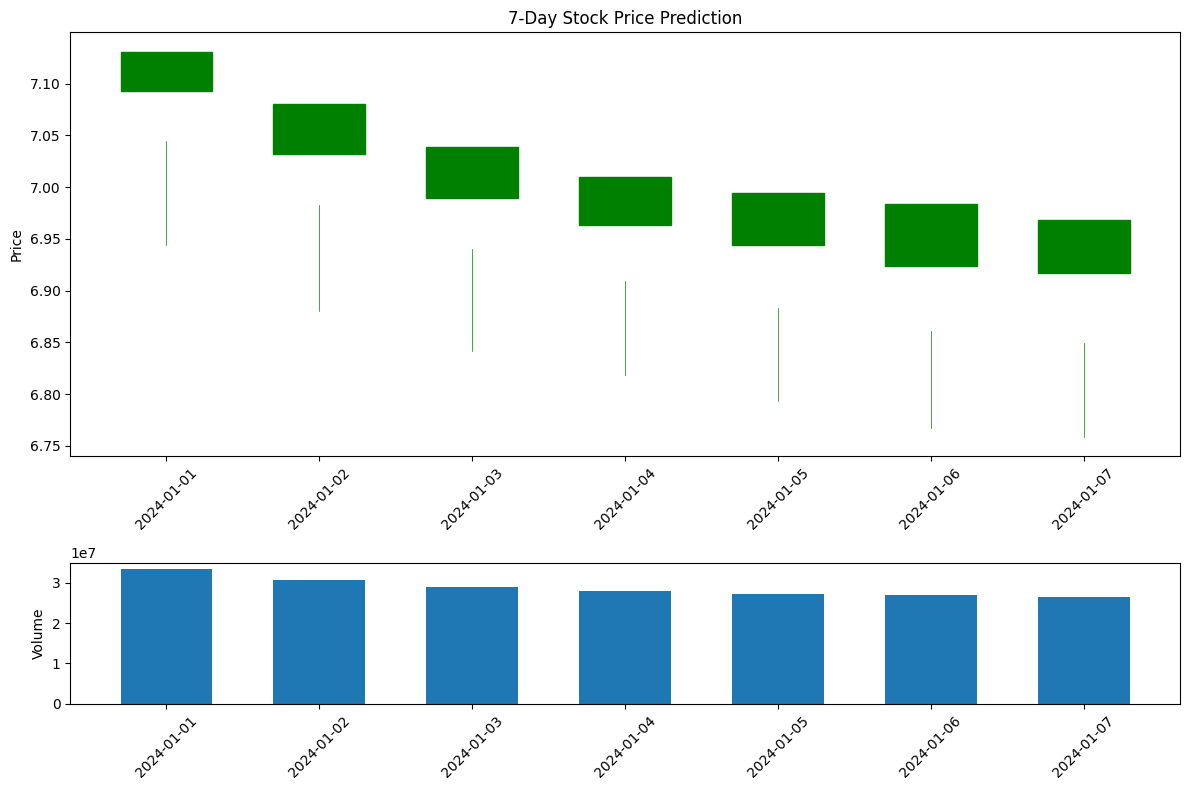

In [37]:
plot_kline(predictions, start_date="2024-01-01")